# Bootstrapping the term structure with 304 bonds

## This notebook calculates the term structure of interest rates for 304 coupon bonds. It utilizes the function developed in Chapters Two and Three, as well as the *Using the linalg module of NumPy* and *Creating the payoff matrix* notebooks from this chapter. The necessary functions are imported from a custom module, demonstrating the ability to skip their development and "leapfrog" over previous chapters and notebooks.


## Importing libraries, modules, and functions

#### As in earlier chapters of the volume, modules that are included in the standard Python library are imported. When necessary, other modules or libraries are installed before they are imported.

```
import sys
import requests
from types import ModuleType
from datetime import datetime, date

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd
```

In [1]:
# Import OS to interact with local computer operating system
import sys
import requests
from types import ModuleType
# Import the datetime and date classes from the datetime module
from datetime import datetime, date

# Import the NumPy library for numerical operations, commonly aliased as np.
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

# Import the pandas library for data manipulation and analysis, aliased as pd.
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

### Adding a custom module and importing functions
The notebook utilizes the custom module, **module_basic_concepts_fixed_income**, sourced from Dropbox and named **basic_concepts_fixed_income**. This module provides three core functions to streamline the focus on financial concepts:

* **one_y_axis** (Chapter One): This function plots zero prices determined via the bootstrapping method.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/one_y_axis.html#one-y-axis-is-a-helper-function-for-plotting-graphs-created-by-financial-python)  
* **accrued_interest** (Chapter Two): This function calculates the accrued interest on a settlement date.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/accrued_interest.html#accrued-interest-is-a-helper-function-that-calculates-accrued-interest)  
* **create_payoff_matrix** (This Chapter): This function calculates the payoff matrix required to bootstrap the term structure with coupon bonds.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/create_payoff_matrix.html)</a>

The module also contains various supporting helper functions, and it automatically manages the import and, if required, installation of necessary libraries and modules. This structure allows the user to concentrate fully on financial principles rather than complex Python implementation details.



```
from basic_concepts_fixed_income import (one_y_axis,
                                        accrued_interest,
                                        create_payoff_matrix)
```





In [2]:
# Define the URL of the Python module to be downloaded from Dropbox.
# The 'dl=1' parameter in the URL forces a direct download of the file content.
url= 'https://www.dropbox.com/scl/fi/4y5hjxlfphh1ngvbgo77q/\
module_-basic_concepts_fixed_income.py?rlkey=6oxi7mgka42veaat79hcv8boz&st=87sztshr&dl=1'
module_name='basic_concepts_fixed_income'
# Send an HTTP GET request to the URL and store the server's response.
try:
  response=requests.get(url)
  # Raise an exception for bad status codes (like 404 Not Found)
  response.raise_for_status()
  module= ModuleType(module_name)
  #Code contained in response.text executed
  exec(response.text, module.__dict__)
  # Module added to sys
  sys.modules[module_name]=module
except requests.exceptions.RequestException as e:
    print(f"❌ Error: Could not fetch module from URL. {e}")
except Exception as e:
    print(f"❌ Error: Failed to execute or import the module. {e}")

# Now that 'basic_concepts_fixed_income' exists in the notebook, import the specific functions
from basic_concepts_fixed_income import (one_y_axis,
                                        accrued_interest,
                                        create_payoff_matrix,
                                        create_workbook)

## Data Used To Estimate The Term Structure
####The 304 U.S. Treasury securities data in the sheet 'Fidelity Data' of the Excel workbook 'Bond Price Data' are used to estimate the zero prices for five years on the settlement date January 21$^{st}$ 2025.  


#### The <font color='green'>read_excel()</font> method converts the workbook sheet into a Pandas DataFrame and requires a URL address.  Here the index of the DataFrame is assigned the first column of the sheet and the sheet is identified as 'Fidelity Data'.



This Fidelity data is downloaded from DropBox and loaded into a Pandas DataFrame using the Panda's <font color='green'>read_excel()</font> method.$^{2}$

Three arguments are passed to the method:



1.    The URL address (<font color='green'>url</font>) is required.
2.    Assigning the index column is optional. The maturity dates, located in the first column, are set as the index of the DataFrame  (<font color='green'>index_col='Maturity Date'</font>).
3.    The worksheet name defaults to the first worksheet. The worksheet's name, 'Fidelity Data', is the assigned sheet (<font color='green'>sheet_name='Fidelity Data'</font>)

The <font color='green'>display()</font>  function shows the first and last five rows confirming that data has been successfully accessed.

---

 $^{2}$ <a href='https://patrickjhess.github.io/Introduction-To-Python-For-Financial-Python/An_Introduction_To_Pandas.html#dataframes-csv-and-excel-files'>Pandas method read_excel</a>

In [3]:
#The full file path.
url='https://www.dropbox.com/scl/fi/lgnaj41bt8o9sv5a63rr1/\
bond_data_jan21_2025.xlsx?rlkey=twjzkcqo0g2ahvot78518ti4x&st=ihc5feog&dl=1'
print(f"Attempting to load data from: {url}")

#Load the data from Excel, using the first column as the index.
try:
    bond_data = pd.read_excel(url, index_col='Maturity Date',sheet_name='Fidelity Data')

    # Display the first and last 5 rows of the loaded DataFrame to verify it worked.
    display(bond_data)

except FileNotFoundError:
    print("\nERROR: File not found.")
    print("Please check that the 'folder' and 'file' variables are spelled correctly'\
' and that the file exists in that location.")

Attempting to load data from: https://www.dropbox.com/scl/fi/lgnaj41bt8o9sv5a63rr1/bond_data_jan21_2025.xlsx?rlkey=twjzkcqo0g2ahvot78518ti4x&st=ihc5feog&dl=1


,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size
Maturity Date,,,,,,
2025-01-28,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.929,99.930,100000.0,100000.0
2025-01-30,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.906,99.907,40000.0,40000.0
2025-01-31,UNITED STATES TREAS SER U-2025 1.3750...,1.375,99.921,99.934,60000.0,60000.0
2025-01-31,UNITED STATES TREAS SER AW-2025 4.1250...,4.125,99.988,99.997,60000.0,60000.0
2025-01-31,UNITED STATES TREAS SER G-2025 2.5000...,2.500,99.953,99.965,60000.0,60000.0
...,...,...,...,...,...,...
2029-11-30,UNITED STATES TREAS SER AG-2029 4.1250...,4.125,98.910,98.914,100000.0,100000.0
2029-11-30,UNITED STATES TREAS SER S-2029 3.8750...,3.875,97.763,97.782,40000.0,40000.0
2029-12-31,UNITED STATES TREAS SER T-2029 3.8750...,3.875,97.734,97.738,65000.0,65000.0


### Identifying bonds that mature On:



*   February 28$^{th}$ 2025
*   July 15$^{th}$ 2025
*   August 31$^{st}$ 2025
*   January 15$^{th}$ 2026
*   February 28$^{th}$ 2026

#### The code segment works as follows:

1. The iterable <font color='green'>maturity_dates</font> is defined, containing five specific dates.  
2. The <font color='green'>sample_bonds</font> DataFrame is created by selecting securities from the <font color='green'>bond_data</font> DataFrame using its <font color='green'>loc</font> attribute.  
3. The final line of code then displays the resulting <<font color='green'>sample_bonds</font> DataFrame.


```
maturity_dates=[date(2025,2,28),date(2025,7,15),date(2025,8,31),
            date(2026,1,15),date(2026,2,28)]
sample_bonds=fixed_data.loc[maturity_dates]
display(sample_bonds)
```



In [4]:
# --- Define a specific list of upcoming bond maturity dates to analyze ---
# These dates were selected for a targeted review of bonds maturing in
# late 2025 and early 2026.
maturity_dates = [
    date(2025, 2, 28),
    date(2025, 7, 15),
    date(2025, 8, 31),
    date(2026, 1, 15),
    date(2026, 2, 28),
]

# Use the .loc indexer to perform a label-based lookup.
# This retrieves all rows where the DataFrame's index exactly matches the dates in our list.
sample_bonds = bond_data.loc[maturity_dates]

# Render the resulting 'sample_bonds' DataFrame as a formatted table in the output.
# display() is preferable to print() for viewing DataFrames in a notebook environment.
display(sample_bonds)

,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size
Maturity Date,,,,,,
2025-02-28,UNITED STATES TREAS NOTE 1.12500% 02/28/2025,1.125,99.671,99.684,60000.0,60000.0
2025-02-28,UNITED STATES TREAS SER AY-2025 4.6250...,4.625,100.019,100.032,60000.0,60000.0
2025-02-28,UNITED STATES TREAS NOTES 2.7500...,2.750,99.837,99.852,40000.0,40000.0
2025-07-15,UNITED STATES TREAS SER AQ-2025 3.0000...,3.000,99.394,99.406,60000.0,60000.0
2025-08-31,UNITED STATES TREAS SER AC-2025 0.2500...,0.250,97.605,97.610,60000.0,60000.0
2025-08-31,UNITED STATES TREAS SER BG-2025 5.0000...,5.000,100.406,100.426,60000.0,60000.0
2025-08-31,UNITED STATES TREAS SER P-2025 2.7500...,2.750,99.070,99.094,60000.0,60000.0
2026-01-15,UNITED STATES TREAS SER AJ-2026 3.8750...,3.875,99.671,99.688,40000.0,40000.0
2026-02-28,UNITED STATES TREAS SER AY-2026 4.6250...,4.625,100.375,100.387,50000.0,50000.0


## The eleven bond example of the notebook *Creating the payoff matrix*.

### Create the payoff matrix for the eleven bonds.

In [5]:
settlement=date(2025,1,21)
freq=2
create_payoff_matrix(sample_bonds,settlement=settlement,freq=freq)

(array([[100.5625,   0.    ,   0.    ,   0.    ,   0.    ],
        [102.3125,   0.    ,   0.    ,   0.    ,   0.    ],
        [101.375 ,   0.    ,   0.    ,   0.    ,   0.    ],
        [  0.    , 101.5   ,   0.    ,   0.    ,   0.    ],
        [  0.125 ,   0.    , 100.125 ,   0.    ,   0.    ],
        [  2.5   ,   0.    , 102.5   ,   0.    ,   0.    ],
        [  1.375 ,   0.    , 101.375 ,   0.    ,   0.    ],
        [  0.    ,   1.9375,   0.    , 101.9375,   0.    ],
        [  2.3125,   0.    ,   2.3125,   0.    , 102.3125],
        [  1.25  ,   0.    ,   1.25  ,   0.    , 101.25  ],
        [  0.25  ,   0.    ,   0.25  ,   0.    , 100.25  ]]),
 [datetime.date(2025, 2, 28),
  datetime.date(2025, 7, 15),
  datetime.date(2025, 9, 2),
  datetime.date(2026, 1, 15),
  datetime.date(2026, 3, 2)])

### Displaying the payoff array of sample_bonds as a Pandas DataFrame.
Using the <font color='green'>create_payoff_matrix</font> function from the custom module *basic\_concepts\_fixed\_income*, the payoff matrix for the sample bonds is generated and stored in the variable <font color='green'>payoffs_11</font>. The unique payment dates are then assigned to  <font color='green'>column_dates_11</font>. Finally, a DataFrame is constructed, utilizing the five unique dates as the column headers and the bonds' maturities as the index.

In [6]:
# Define settlement date and payment frequency
settlement=date(2025,1,21)
freq=2

# create_payoff_matrix returns payment rows for each bond and unique payment dates
payoffs_11,column_dates_11=create_payoff_matrix(sample_bonds,settlement=settlement,freq=freq)

# Pandas DataFrame created from two-dimensional NumPy array payoffs_11
pd.DataFrame(payoffs_11,columns=column_dates_11,index=sample_bonds.index)

,2025-02-28,2025-07-15,2025-09-02,2026-01-15,2026-03-02
Maturity Date,,,,,
2025-02-28,100.5625,0.0000,0.0000,0.0000,0.0000
2025-02-28,102.3125,0.0000,0.0000,0.0000,0.0000
2025-02-28,101.3750,0.0000,0.0000,0.0000,0.0000
2025-07-15,0.0000,101.5000,0.0000,0.0000,0.0000
2025-08-31,0.1250,0.0000,100.1250,0.0000,0.0000
2025-08-31,2.5000,0.0000,102.5000,0.0000,0.0000
2025-08-31,1.3750,0.0000,101.3750,0.0000,0.0000
2026-01-15,0.0000,1.9375,0.0000,101.9375,0.0000
2026-02-28,2.3125,0.0000,2.3125,0.0000,102.3125


## <font color='green'>Application: Determine the payoff matrix for the first twenty bonds in bond_data DataFame</font>

<div style="
    border-left: 12px solid green;
    line-height: 1.5;
    padding: 15px">
<br>


see [Chapter Four Hints: payoff matrix first 20 bonds](https://colab.research.google.com/drive/1hSV2ArS-kEm3soW-sbIBTjWnnD3nMvkh#scrollTo=nFsV0fH8m2Nh) and check the [expected results here](https://colab.research.google.com/drive/1hrv5WQPxxuto7jIy1I6_fdyeAyhNCLaY#scrollTo=nFsV0fH8m2Nh).

<div>

## Estimate zero prices for the five unique dates of the sample_bonds DataFrame

### Calculating accrued interest and transaction prices
The transaction prices for the eleven bonds are assigned their bid/ask average plus accrued interest.
The process involves two main steps:

1. **Calculate Bid/Ask Average:** The average is computed using the 'Price Bid' and 'Price Ask' columns in the DataFrame.  
2. **Update DataFrame:** The 'Accrued' column is added to <font color='green'>sample_bonds</font> DataFrame using the Pandas  <font color='green'>apply()</font> method and the 'Transaction Prices' column is added by adding accrued interest to the Bid/Ask average.

In [7]:
# apply the accrued_interest function to the DataFrame to populate a new column 'Accrued'
sample_bonds['Accrued'] = sample_bonds.apply(
    lambda x: accrued_interest(
        maturity=x.name, # Assuming index is maturity
        coupon=x['Coupon'],
        settlement=settlement,
        freq=2,
        day_type='Actual/Actual'
    ), axis=1
)

# The new column 'Transaction Prices' equals accrued interest plus the Bid/Ask average
sample_bonds['Transaction Prices']=(sample_bonds['Price Bid']+sample_bonds['Price Ask'])/2\
+sample_bonds['Accrued']
sample_bonds

,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size,Accrued,Transaction Prices
Maturity Date,,,,,,,,
2025-02-28,UNITED STATES TREAS NOTE 1.12500% 02/28/2025,1.125,99.671,99.684,60000.0,60000.0,0.444406,100.121906
2025-02-28,UNITED STATES TREAS SER AY-2025 4.6250...,4.625,100.019,100.032,60000.0,60000.0,1.827003,101.852503
2025-02-28,UNITED STATES TREAS NOTES 2.7500...,2.750,99.837,99.852,40000.0,40000.0,1.086326,100.930826
2025-07-15,UNITED STATES TREAS SER AQ-2025 3.0000...,3.000,99.394,99.406,60000.0,60000.0,0.049724,99.449724
2025-08-31,UNITED STATES TREAS SER AC-2025 0.2500...,0.250,97.605,97.610,60000.0,60000.0,0.099185,97.706685
2025-08-31,UNITED STATES TREAS SER BG-2025 5.0000...,5.000,100.406,100.426,60000.0,60000.0,1.983696,102.399696
2025-08-31,UNITED STATES TREAS SER P-2025 2.7500...,2.750,99.070,99.094,60000.0,60000.0,1.091033,100.173033
2026-01-15,UNITED STATES TREAS SER AJ-2026 3.8750...,3.875,99.671,99.688,40000.0,40000.0,0.064227,99.743727
2026-02-28,UNITED STATES TREAS SER AY-2026 4.6250...,4.625,100.375,100.387,50000.0,50000.0,1.827003,102.208003


### Use the <font color='green'>lstsq</font> of linalg module of NumPy library

The process for calculating estimated coefficients (zero prices) using the <font color='green'>lstsq</font> function from NumPy's linalg module is as follows:

1. **Define the NumPy Array:** Convert the 'Transaction Prices' column into a NumPy array named <font color='green'>transaction_prices</font> using the Pandas  <font color='green'>to_numpy</font> method.  
2. **Execute the  <font color='green'>lstsq</font> function:** Call the  <font color='green'>lstsq</font> function to perform the least-squares solution. The outputs of this function are assigned to the following variables:  
   * **Estimated Coefficients (zero prices):**  <font color='green'>zero_prices_11</font>  
   * **Sum of Squared Residuals:**  <font color='green'>ss2_11</font>  
   * **Rank of Payoff Matrix:** <font color='green'>rank_11</font>  
   * **Relative Information Content of Payoff Matrix Columns:**  <font color='green'>colInfo_11</font>
  
3. **Generate Output DataFrames:**  
   * **Term Structure DataFrame:** <font color='green'>df_11</font> contains the calculated zero prices, along with the annualized spot and forward rates for the five unique dates.  
   * **Summary Statistics DataFrame:** <font color='green'>df_summary_11</font> includes the average of squared residuals, the rank of the payoff matrix, and the minimum and maximum values of the estimated information content for the columns.

In [8]:
# Calculate transaction prices
transaction_prices=sample_bonds['Transaction Prices'].to_numpy()

# Estimate the present value factors with least squares
zero_prices_11,ss2_11,rank_11,colInfo__11=np.linalg.lstsq(payoffs_11,transaction_prices)

# Maturity of the bonds in years
maturity_years=[(mat_date-settlement).days/365 for mat_date in column_dates_11]

# Continuously compounded annualized spot rates
spot_rates_11=-np.log(zero_prices_11)/np.array(maturity_years)

# Continuously compounded annualized forward rates
forward_rates_11=-np.diff(np.log(zero_prices_11))/np.diff(maturity_years)
forward_rates_11=np.insert(forward_rates_11,0,np.nan)

# Create a DataFrame of least squares present value estimates and display results
# First a dictionary
bonds_11={'Zero Pries: 11 Bonds':zero_prices_11,
          'Spot Rates:11 Bonds':spot_rates_11,
          'Forward Rates: 11 Bonds':forward_rates_11}
# Then a DataFrame
df_11=pd.DataFrame(bonds_11,index=column_dates_11)
display(df_11)

# Create a DataFrame of summary statistics and display results
# First a dictionary
summary_11={'Average Sum Squared Errors':ss2_11/len(sample_bonds),
             'Payoff Rank':rank_11,
             'Column Max Info':np.max(colInfo__11),
             'Column Min Info':np.min(colInfo__11)}

df_summary_11=pd.DataFrame(summary_11,index=['Summary Statistics']).T
display(df_summary_11)

/tmp/ipykernel_28077/4195404125.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  zero_prices_11,ss2_11,rank_11,colInfo__11=np.linalg.lstsq(payoffs_11,transaction_prices)


,Zero Pries: 11 Bonds,Spot Rates:11 Bonds,Forward Rates: 11 Bonds
2025-02-28,0.995580,0.042547,NaN
2025-07-15,0.979800,0.042562,0.042566
2025-09-02,0.974662,0.041819,0.039166
2026-01-15,0.959856,0.041656,0.041386
2026-03-02,0.954456,0.042010,0.044773


,Summary Statistics
Average Sum Squared Errors,0.000018
Payoff Rank,5.000000
Column Max Info,177.808521
Column Min Info,100.730222


## The eleven bond results
The estimated spot and forward rates are both annualized at approximately 4%. In contrast to the findings in Chapter One, the term structure in January of 2025 is flat, showing neither the upward trend seen in September 2022 nor the downward trend of September 2025. The reliability of the estimated zero prices is determined by the ratio of the maximum and minimum column information values; extremely high values indicate unreliable estimates. The observed values confirm that our estimates are, in fact, reliable.


## <font color='green'>Application: Estimate the term structure with the first twenty five bonds</font>


<div style="
    border-left: 12px solid green;
    line-height: 1.5;
    padding: 15px">
<br>

Create DataFrames for the term structure and summary statistics.

#### see [Chapter Three Hints: payoff matrix first 20 bonds](https://colab.research.google.com/drive/1hSV2ArS-kEm3soW-sbIBTjWnnD3nMvkh#scrollTo=nFsV0fH8m2Nh) and check the [expected results here](https://colab.research.google.com/drive/1hrv5WQPxxuto7jIy1I6_fdyeAyhNCLaY#scrollTo=nFsV0fH8m2Nh).

<br>
</div>

## Estimate zero prices for 149 unique dates with 304 bonds of bond_data DataFrame

In [9]:
# apply the accrued_interest function to the DataFrame
bond_data['Accrued'] = bond_data.apply(
    lambda x: accrued_interest(
        maturity=x.name, # Assuming index is maturity
        coupon=x['Coupon'],
        settlement=settlement,
        freq=2,
        day_type='Actual/Actual'
    ), axis=1
)

# Calculate transaction prices
transaction_prices=((bond_data['Price Bid']+bond_data['Price Ask'])/2+
                    bond_data['Accrued']).to_numpy()

# Create payoff matrix
payoffs_304,column_dates_304=create_payoff_matrix(bond_data,settlement=settlement,freq=2)

# Estimate the present value factors with least squares
zero_prices_304,ss2_304,rank_304,colInfo_304=np.linalg.lstsq(payoffs_304,transaction_prices)

# Maturity of the bonds in years
maturity_years=[(mat_date-settlement).days/365.25 for mat_date in column_dates_304]


# Continuously compounded annualized spot rates
spot_rates_304=-np.log(zero_prices_304)/np.array(maturity_years)

# Continuously compounded annualized forward rates
forward_rates_304=-np.diff(np.log(zero_prices_304))/np.diff(maturity_years)
forward_rates_304=np.insert(forward_rates_304,0,np.nan)

# Create a DataFrame of least squares present value estimates and display results
# First a dictionary
bonds_304={'Zero Prices: 304':zero_prices_304,
           'Spot Rates:304':spot_rates_304,
           'Forward Rates: 304':forward_rates_304}

# Then a DataFrame
df_304=pd.DataFrame(bonds_304,index=column_dates_304)
display(df_304)

# Create a DataFrame of summary statistics and display results
# First a dictionary
summary_304={'Average Sum Squared Errors':ss2_304/len(bond_data),
             'Payoff Rank':rank_304,
             'Column Max Info':np.max(colInfo_304),
             'Column Min Info':np.min(colInfo_304)}
# Then a DataFrame
df_summary_304=pd.DataFrame(summary_304,index=['Summary Statistics']).T
display(df_summary_304)

/tmp/ipykernel_28077/2585489679.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  zero_prices_304,ss2_304,rank_304,colInfo_304=np.linalg.lstsq(payoffs_304,transaction_prices)


,Zero Prices: 304,Spot Rates:304,Forward Rates: 304
2025-01-28,0.999295,0.036799,NaN
2025-01-30,0.999065,0.037963,0.042038
2025-01-31,0.998886,0.040711,0.065439
2025-02-04,0.998475,0.039817,0.037581
2025-02-06,0.998240,0.040213,0.042987
...,...,...,...
2029-10-31,0.812875,0.043390,0.043360
2029-11-15,0.809539,0.043874,0.100158
2029-11-30,0.809936,0.043402,-0.011943
2029-12-31,0.806965,0.043400,0.043302


,Summary Statistics
Average Sum Squared Errors,0.011753
Payoff Rank,149.000000
Column Max Info,267.431046
Column Min Info,100.000000


## The 304 bond results

There is a slight upward trend in the term structure between shortest maturity (three days) and five years. As was true for the eleven bonds, the ratio of the maximum and minimum column information values confirm that our estimates are, in fact, reliable.  Two forward rates, however, stand out.

### Notable forward rate estimates

Estimates for the last five dates show two striking results:

1. **An annualized forward rate of over 10%** for the 15-day period between October 31$^{st}$ to November 15$^{th}$ 2029.

2. **A negative annualized forward rate of -1%** for the subsequent 15 days,  November 15$^{th}$ to November 30$^{th}$, 2029.

Because the zero price on November 15$^{th}$ 2029 is too high, the October 31$^{st}$ spot rate is high and the forward rate for the next fifteen days is negative.

It is highly probable that there are other instances of negative estimates of forward rates. Negative estimates may be actual arbitrage opportunities or simply due to:

* **Non-Coincident Prices:** Although the bond prices are downloaded simultaneously, it is unlikely they are updated at the exact same moment. Consequently, apparent arbitrage opportunities may simply be a reflection of stale pricing.

* **Bid/Ask Spread:** We use the average of the bid and ask prices as the quoted price. However, actual transactions involve a small cost, as we cannot buy and sell at the identical price.  


Below the estimated zero prices are used to value the 304 bonds.  That analysis shows larger pricing errors in the longer maturity bonds. There we discuss how these discrepancies would influence portfolio decisions.


## Plot Least Squares (OLS) Zero Price Estimates for 149 unique dates

The function <font color='green'>one_y_axis</font> of Chapter One is used to plot the zero prices derived from the 304 bonds. It is worth noting that a small number of these estimated zero prices are marginally higher than their preceding values.

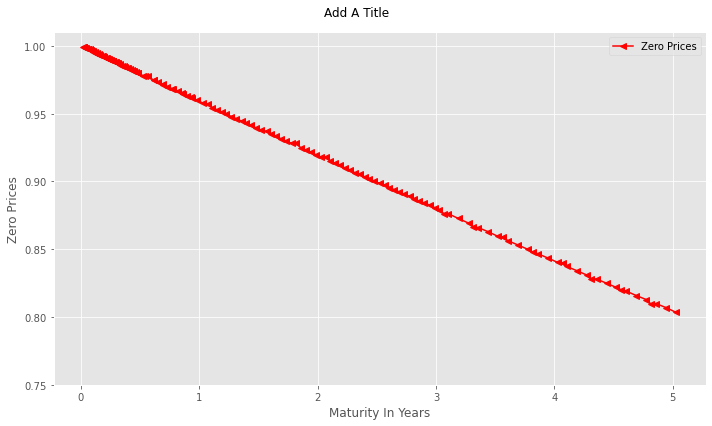

In [10]:
settlement=date(2025,1,21)

# Initialize a dictionary to hold plot-saving configurations.
save_config={}

# Calculate the time to maturity in years for each data point
years=[(pay_date-settlement).days/365.25 for pay_date in column_dates_304]

# Initialize a dictionary to hold plot-saving configurations.
save_config={}
string_date='01/21/2025'

# Set the x-axis and y-axis data for the plot.
xaxis=years              #Maturity relative to 1/21/2025
data=[df_304['Zero Prices: 304']]       #y-axis data

# Define the file name and folder for the saved plot.


# Attempt to extract the plot title from the file name.
try:
    title = save_config['File Name'][:-4]
#'File' key not found or string is too short), set a default title.
except:
    title = 'Add A Title'

# Define labels for the data series, y-axis, and x-axis.
series=['Zero Prices']
ylabel='Zero Prices'
xlabel='Maturity In Years'

# Set plot aesthetics: marker styles, y-axis limits, figure size, and color.
markers=['<']
ylim=[0.75,1.01]
size=(10,6)
# Define colors as red
colors=['r']

# Call the plotting function with all the prepared data and configurations
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

# ***Pricing Bonds With Zero Price Estimates***

The zero price estimates can be used to price bonds with payment dates matching the dates of the zero price estimates.  Because the zero estimates are derived from the 304 bonds, the dates of the zero price and the bond payments match. The array of predicted bond prices equal:

$$Predicted\ Prices=Payoff\ Array\times Zero\ Price\ Estimates$$

The array of pricing errors equals:

 $$Pricing\ Errors=Predicted\ Prices - Transaction\ Prices$$

The pricing errors, plotted against the bonds' maturities, are generally less than twenty-five cents, though three errors are approximately fifty cents. These pricing discrepancies represent between 25 and 50 basis points relative to the bonds' par value. Had these prices been executable, the errors indicate the potential for arbitrage profits.

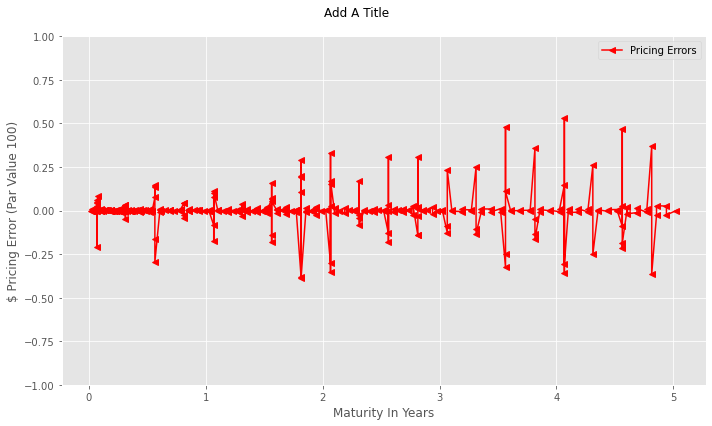

In [11]:
predicted_prices=payoffs_304@zero_prices_304
pricing_errors=predicted_prices-transaction_prices
years=[(date_obj-settlement).days/365.25 for date_obj in
       pd.to_datetime(bond_data.index).date]
save_config={}
string_date='01/21/2025'
xaxis=years              #Maturity relative to 1/21/2025
data=[pricing_errors]       #y-axis data
# Attempt to extract the plot title from the file name.
try:
    title = save_config['File Name'][:-4]
#'File' key not found or string is too short), set a default title.
except:
    title = 'Add A Title'
series=['Pricing Errors']
ylabel='$ Pricing Error (Par Value 100)'
xlabel='Maturity In Years'
x=len(data)
markers=['<']
ylim=[-1,1.]
size=(10,6)
colors='r'
one_y_axis(xaxis,data,title,series,xlabel,ylabel,markers,size,ylim,
           save_config=save_config,colors=colors)

## How would investors use this analysis

The pricing errors quantify the relative value among the 304 bonds. Taken at face value, these errors suggest potential return enhancement for investors through the sale of overvalued bonds (indicated by negative pricing errors) and the purchase of undervalued bonds (indicated by positive pricing errors). An enhancement that could be achieved by:

1. **An Arbitrage Trade:** Executing trades designed to capture profit with minimal or no risk.  
2. **A Quasi-Arbitrage Trade (Portfolio Tilting):** Adjusting portfolios by decreasing exposure to overvalued bonds and increasing exposure to undervalued bonds.

Both strategies require effective control of the risks associated with the return-enhancing trades. For bonds like those issued by the U.S. Treasury with low default risk, the most critical risk is unexpected changes in interest rates. Although the concept is intuitively linked to present value factors, the specific methods for measuring this interest rate risk—duration and convexity—are detailed in two forthcoming chapters.

## <span style="text-align: left; color:green; font-family: 'Franklin Gothic Medium', sans-serif; margin-top: 1.0em; margin-bottom: 0em; font-style: italic;">Chapter Exercise</span>
<span style="text-align: left; color:green; font-family: 'Franklin Gothic Medium', sans-serif; margin-top: 0; margin-bottom: 0.5em; font-style: italic;
"><big>Using the term structure calculated with 304 bonds</big>
</span>


Calculate the forward rates for the following dates.


|Start Date|End Date|
|-------|-------|
|&nbsp;&nbsp;&nbsp;January 28$^{th}$ 2025|&nbsp;&nbsp;&nbsp;February 2$^{nd}$ 2026|
|&nbsp;&nbsp;&nbsp;February 2$^{nd}$ 2026|&nbsp;&nbsp;&nbsp;February 1$^{st}$ 2027|
|&nbsp;&nbsp;&nbsp;February 1$^{st}$ 2027|&nbsp;&nbsp;&nbsp;January 31$^{st}$ 2028|
|&nbsp;&nbsp;&nbsp;January 31$^{st}$ 2028|&nbsp;&nbsp;&nbsp;January 31$^{st}$ 2030|
|




 see [Chapter Four Hints: Using 304 bond term structure estimates](https://colab.research.google.com/drive/1hSV2ArS-kEm3soW-sbIBTjWnnD3nMvkh#scrollTo=gTwsGdLgxMCB), and check the [expected results here](https://colab.research.google.com/drive/1hrv5WQPxxuto7jIy1I6_fdyeAyhNCLaY#scrollTo=gTwsGdLgxMCB).

